In [1]:
# This tutorial is an extension of tutorial 1, where we got vertical potential and characteristics 
# stellar populations at Rsun. Now we model stellar populations in the volume (sphere centered at the Sun), 
# also applying some observaionally-motivated selecion criteria (e.g., magnitude cuts). 

# Firstly, we import all necessary packages, classes, functions, and model parameters:
import os
import random
import numpy as np
import healpy as hp 
from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from healpy import mollview, graticule
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from multiprocessing import Pool
from fast_histogram import histogram2d
from scipy.signal import savgol_filter
from jjmodel.input_ import p,a, inp
from jjmodel.tools import convolve1d_gauss, convolve2d_gauss
from jjmodel.iof import dir_tree, tab_reader
from jjmodel.geometry import Grid
from jjmodel.analysis import pops_in_volume
from jjmodel.constants import tp, tr
from jjmodel.mwdisk import disk_builder
from jjmodel.funcs import IMF, SFR
from jjmodel.analysis import GetPopulations, fw_hist
from jjmodel.tools import Timer
from jjmodel.populations import stellar_assemblies_r



Parameter file(s) : ok.
Number of parameters =  66 , among them technical =  6

 p(run_mode=0, out_dir='tutorial3', out_mode=1, nprocess=4, Rsun=8.2, zsun=20, zmax=2000, dz=2, sigmad=29.3, sigmat=4.9, sigmag1=2.0, sigmag2=11.0, sigmadh=51.9, sigmash=0.47, td1=0, td2=7.8, dzeta=0.8, eta=5.6, pkey=1, tt1=0.1, tt2=4, gamma=2, beta=3.5, imfkey=0, a0=1.31, a1=1.5, a2=2.88, a3=2.28, m0=0.49, m1=1.43, m2=6.0, FeHd0=-0.7, FeHdp=0.29, rd=0.34, q=-0.72, k_FeHdp=-0.0875, dFeHdt=0, n_FeHdt=1, FeHt0=-0.94, FeHtp=0.04, rt=0.77, t0=0.97, FeHsh=-1.5, dFeHsh=0.4, n_FeHsh=5, alpha=0.375, sige=26.0, sigt=45, sigdh=140, sigsh=100, sigmap=array([3.5, 1.3]), tpk=array([10. , 12.5]), dtp=array([0.7 , 0.25]), sigp=array([26.3, 12.6]))

Parameters checked: 0 Reminders, 0 Warnings, 0 Errors.

Configuration finished:  0h 0m 0.17s


In [2]:
# Run the disk_builder function to solve Poisson-Boltzmann eq. at Rsun:

if __name__ == '__main__':
    disk_builder(p,a,inp,status_progress=True)


Results of this run will be saved to already existing folder output/Rsun8.2_tutorial3

Output directory tree created.

---Local run---

  Process for R = 8.2 kpc: start       
    Process for R = 8.2 kpc: fimax optimized
      Process for R = 8.2 kpc: PE solved   
        Process 8.2   : exit, time: 0h 0m 0.57s


Input data saved.

Output data saved.

---Local run ended sucessfully---



In [3]:
# Define IMF and create stellar assemblies (SA): 

M_low, M_up = 0.08, 100      # Msun, lower and upper IMF mass limits
imf = IMF(M_low,M_up)
mass, Nmdm = imf.BPL_4slopes(p.a0,p.a1,p.a2,p.a3,p.m0,p.m1,p.m2)

timer = Timer()
t_start = timer.start()

if __name__ == '__main__':
    stellar_assemblies_r(p.Rsun,p,a,inp['AMRd0'],inp['AMRt'],inp['SFRd0'],inp['SFRt0'],
                         p.sigmash,imf.number_stars,'Padova',3)
    
print('\n',timer.stop(t_start))



Stellar population synthesis for R = 8.2 kpc:
Warning. Some of modeled metallicities (halo) are outside of Padova metallicity range [-2.2,0.5], 
i.e., the adopted best isochrones may be not representative.
	thin disk	thick disk	halo

 0h 0m 17.8s


In [4]:
# Additional parameters
# -------------------------

# Let's assume that we are interested in stars in some range of apparent G-magnitude...
Gmin = -10                            # mag 
Gmax =  20                            # mag
# ...and within some range of distances from the Sun (local sphere or shell). 
d_helio_min = 0                     # pc, inner radius of the shell
d_helio_max = 25                    # pc, outer radius of the shell


In [17]:
# Grid, output array, and SA tables
# ------------------------------------

# Create spatial grid in the local cylindrical coordinates:
# z            -    goes from -zmax to +zmax with a step p.dz
# r (xy-plane) -    goes from 0 to rmax with a number of bins rnum 

zmax = p.dz*((d_helio_max + p.zsun + 5)//p.dz)  # optimal zmax (sphere fits into selected z-range, 
                                                # too large and empty z-bins are not included)
    
rmin, rmax = 0, d_helio_max                     # pc, min and max r at each z-bin. You can make a cylindrical 
                                                # hole in your volume if you set rmin > 0 (but < rmax)
    
rnum = 20                                       # number of steps along r-axis, 
                                                # usually rmax/rnum ~ 1-5 pc is a good choice
G = Grid(zmax,p.dz,rmax,rnum)
grid = G.make()

# Indeces of r- and z-bins to be used (not all created z-bins will be needed)
z_index = np.where((grid.z>p.zsun-d_helio_max-1)&(grid.z<p.zsun+d_helio_max+1))[0]
r_index = G.indr(rmin,rmax)

# Create empty output arrays:

# We define magnitude and distance ranges and steps 
# for the output Hess diagram and star counts histrogram:
mag_range = [[-0.25,1.5],[-5,15]]   # mag, range of magnitudes for the Hess diagram (G-GRP, M_G)
mag_step = [0.005,0.1]              # step in G-GRP and M_G (Hess diagram resolution)
mag_smooth = [0.05,0.3]             # mag, define width of the Gaussian kernel for smoothing
xlen = int(round(abs((mag_range[0][0]-mag_range[0][1])/mag_step[0]),0)) 
ylen = int(round(abs((mag_range[1][0]-mag_range[1][1])/mag_step[1]),0))
hess = np.zeros((3,xlen,ylen))

d_helio_step = 1                    # pc, step in distance 
dbins = np.arange(d_helio_min,d_helio_max+d_helio_step,d_helio_step)
dbinsc = np.add(dbins,d_helio_step/2)[:-1]
Nd = np.zeros((3,len(dbinsc)))

t_step = 0.1                        # Gyr
tbins = np.arange(0,tp+t_step,t_step)
tbinsc = np.add(tbins,t_step/2)[:-1]
thist = np.zeros((3,len(tbinsc)))

fe_step = 0.02                      # dex 
febins = np.arange(-1,0.6+fe_step,fe_step)
febinsc = np.add(febins,fe_step/2)[:-1]
fehist = np.zeros((3,len(febinsc)))

w_step = 2                          # km/s
wbins = np.arange(0,60+w_step,w_step)
wbinsc = np.add(wbins,w_step/2)[:-1]
fw = np.zeros((3,len(wbinsc)))

l_step, b_step = 1, 1               # deg 
lnum, bnum = int(round(360/l_step,0)), int(round(180/b_step,0))
lbinsc = np.linspace(0+l_step/2,360-l_step/2,lnum)
bbinsc = np.linspace(-90+b_step/2,90-b_step/2,bnum)
lb_map = np.zeros((3,lnum,bnum))

# Read SA tables
T = dir_tree(p)
tabd = tab_reader('ssp',p,T,R=p.Rsun,mode='d',tab=True,mode_iso='Padova')
tabt = tab_reader('ssp',p,T,R=p.Rsun,mode='t',tab=True,mode_iso='Padova')
tabsh = tab_reader('ssp',p,T,R=p.Rsun,mode='sh',tab=True,mode_iso='Padova')
tabs = {'d':tabd,'t':tabt,'sh':tabsh}



Grid initialization... ok



In [18]:
# Useful functions
# ------------------------------------

def r_cycle(tabs,z_rand,l_rand,rlim,zlim,d_helio_lim,Glim,
            xylen,mag_range,dbins,tbins,febins,wbins,lbinsc,bbinsc,p):
    '''
    This function takes the SA table (tab) and assigns each SA with
    heliocentric distance in the given range of z and r (parameters rmin, rmax, and z_rand).
    Then it calculates SA apparent magnitudes and applies the magnitude cut. 
    Also, the distnce cut is applied (to define volume). 
    The number of stars is calculated in this rz-cell, which is then used to calculate 
    quantities of interest - Hess diagram, age, metallicity, spatial and |W| distributions...
    '''
    
    mode_comp = ['d','t','sh']
    hess, Nd, thist, fehist, fw, lb_map = [],[],[],[],[],[]
    
    rmin, rmax = rlim 
    rz_volume = np.pi*(rmax+rmin)*(rmax-rmin)*p.dz    # volume of the rz-cell 
    
    for i in range(len(mode_comp)):
        
        tab = tabs[mode_comp[i]]
        
        # Assign heliocentric distance to each stellar population
        r_rand = np.array([random.uniform(rmin,rmax) for i in tab['N']])
        d_helio_rand = np.sqrt(np.multiply(r_rand,r_rand) +\
                               np.multiply(np.subtract(z_rand[i],p.zsun),np.subtract(z_rand[i],p.zsun)))
        
        # Assign latitude (calculated with respect to z_sun, not z=0 pc plane)
        # If you compare model to some data, use the same definition for calculating b in the data and model.
        b_rand = np.arctan(np.divide(np.subtract(z_rand[i],p.zsun),r_rand))
    
        # De-reddened G-magnitude 
        Gmag = tab['G_EDR3'] + 5*np.log10(d_helio_rand) - 5 
    
        # Applying distance and magnitude cuts
        ind_sample = np.where((d_helio_rand>=d_helio_lim[0])&(d_helio_rand<=d_helio_lim[1])&
                              (Gmag>=Glim[0])&(Gmag<=Glim[1]))[0]
    
        # Calculating the number of stars in this volume cell 
        NiV = pops_in_volume(mode_comp[i],p.Rsun,rz_volume,p,a,tab=tab[ind_sample],zlim=zlim)

        # Get the output 
        hess.append(histogram2d(np.subtract(NiV['G_EDR3'],NiV['GRP_EDR3']),NiV['G_EDR3'],
                                weights=NiV['Nz'],bins=xylen,range=mag_range))
        Nd.append(np.histogram(d_helio_rand[ind_sample],bins=dbins,weights=NiV['Nz'])[0])
        thist.append(np.histogram(tab['age'][ind_sample],bins=tbins,weights=NiV['Nz'])[0])
        fehist.append(np.histogram(tab['FeH'][ind_sample],bins=febins,weights=NiV['Nz'])[0])
        fw.append(fw_hist(mode_comp[i],p.Rsun,zlim,p,a,tab=tab,wmax=wbins[-1],dw=np.diff(wbins)[0])[0]*\
                  (np.diff(wbins)[0]*sum(NiV['Nz'])))
        lb_map.append(histogram2d(l_rand[i][ind_sample],np.rad2deg(b_rand[ind_sample]),weights=NiV['Nz'],
                                  bins=[len(lbinsc),len(bbinsc)],range=[[0,360],[-90,90]]))

    return (hess, Nd, thist, fehist, fw, lb_map)


In [19]:
# Main body 
# -----------------------------------------

# Run for all rz-bins:
for i in range(len(z_index)):
    
    k = z_index[i]
    print('z =',str(grid.zc[k]),'pc')
    
    # Spread in z within this z-slice and spread in longitude l (for the disk and halo) 
    z_rand = [[random.uniform(grid.z[k],grid.z[k+1]) for i in table] for table in [tabd['N'],tabt['N'],tabsh['N']]]
    l_rand = [np.array([random.uniform(0,360) for i in table]) for table in [tabd['N'],tabt['N'],tabsh['N']]]
    
    # Define function for pool
    def r_cycle_pool(j):
        return r_cycle(tabs,z_rand,l_rand,[grid.r[j],grid.r[j+1]],[grid.z[k],grid.z[k+1]],
                       [d_helio_min,d_helio_max],[Gmin,Gmax],
                       [xlen,ylen],mag_range,dbins,tbins,febins,wbins,lbinsc,bbinsc,p)    
    
    # Process all r-bins at this z using multiprocessing
    if __name__ == '__main__':
        pool = Pool(processes = p.nprocess)
        out = pool.map(r_cycle_pool,r_index)
        pool.close()
        pool.join()

    # Get the output
    for i in range(len(out)):
        hess = np.add(hess,out[i][0])
        Nd = np.add(Nd,out[i][1])
        thist = np.add(thist,out[i][2])
        fehist = np.add(fehist,out[i][3])
        fw = np.add(fw,out[i][4])
        lb_map = np.add(lb_map,out[i][5])


z = -3.0 pc
z = -1.0 pc
z = 1.0 pc
z = 3.0 pc
z = 5.0 pc
z = 7.0 pc
z = 9.0 pc
z = 11.0 pc
z = 13.0 pc
z = 15.0 pc
z = 17.0 pc
z = 19.0 pc
z = 21.0 pc
z = 23.0 pc
z = 25.0 pc
z = 27.0 pc
z = 29.0 pc
z = 31.0 pc
z = 33.0 pc
z = 35.0 pc
z = 37.0 pc
z = 39.0 pc
z = 41.0 pc
z = 43.0 pc
z = 45.0 pc


d:  4238 , t:  267 , sh:  16 , tot:  4521


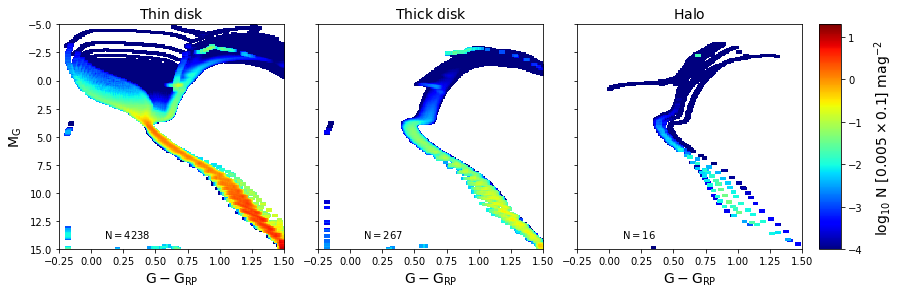

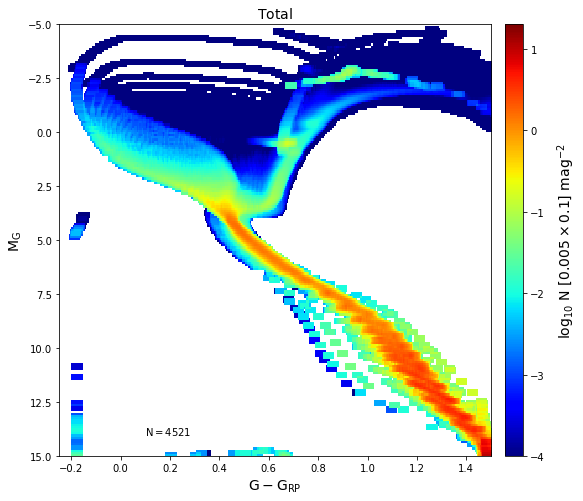

In [8]:
# Hess diagram
# --------------------------------

# Smooth the diagrams
hessd = convolve2d_gauss(hess[0],mag_smooth,mag_range)
hesst = convolve2d_gauss(hess[1],mag_smooth,mag_range)
hesssh = convolve2d_gauss(hess[2],mag_smooth,mag_range)
hesstot = convolve2d_gauss(hess[0]+hess[1]+hess[2],mag_smooth,mag_range)

# Total predicted number of stars
Nd_tot = int(np.round(np.sum(np.sum(hessd)),0))
Nt_tot = int(np.round(np.sum(np.sum(hesst)),0))
Nsh_tot = int(np.round(np.sum(np.sum(hesssh)),0))
Ntot = [Nd_tot,Nt_tot,Nsh_tot] 
N_tot = Nd_tot + Nt_tot + Nsh_tot
print('d: ',Nd_tot,', t: ',Nt_tot,', sh: ',Nsh_tot,', tot: ',N_tot)

# Convert to log space
def log_hess(hess):
    hess[hess==0]=np.nan
    log_hess = np.log10(hess)
    return log_hess

log_hessd = log_hess(hessd)
log_hesst = log_hess(hesst)
log_hesssh = log_hess(hesssh)
log_hesstot = log_hess(hesstot)

# Plot the results
fnt1, fnt2 = 14, 10
hmin, hmax = 0.1*(np.nanmin(log_hesstot)//0.1 - 1), 0.1*(np.nanmax(log_hesstot)//0.1 + 1)
if hmin < -4: 
    hmin = -4 
components = ['$\mathrm{Thin \ disk}$','$\mathrm{Thick \ disk}$','$\mathrm{Halo}$','$\mathrm{Total}$']


f, ax = plt.subplots(ncols=3,nrows=1,figsize=(12,9))        
im = ax[0].imshow(log_hessd.T,interpolation='none',cmap='jet',vmin=hmin,vmax=hmax,
                  extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]])
ax[1].imshow(log_hesst.T,interpolation='none',cmap='jet',vmin=hmin,vmax=hmax,
             extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]])
ax[2].imshow(log_hesssh.T,interpolation='none',cmap='jet',vmin=hmin,vmax=hmax,
             extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]])  
ax[0].set_ylabel('$\mathrm{M_G}$',fontsize=fnt1)
f.subplots_adjust(bottom=0.18,left=0.08,right=0.94,top=0.93,wspace=0.15)
for i in range(3):
    ax[i].set_aspect((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0]))
    ax[i].text(0.2,0.05,'$\mathrm{N='+str(Ntot[i])+'}$',fontsize=fnt2,transform=ax[i].transAxes)
    ax[i].set_xlabel('$\mathrm{G - G_{RP}}$',fontsize=fnt1)
    ax[i].set_title(components[i],fontsize=fnt1)
    if i!=0:
        ax[i].set_yticklabels([])
pos = ax[2].get_position()
cax = f.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = f.colorbar(im,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10} \ N \ ['+str(mag_step[0])+
               r'\times'+str(mag_step[1])+'] \ mag^{-2}}$',labelpad=10,fontsize=fnt1)
plt.show()



f, ax = plt.subplots(figsize=(10,8))        
im = ax.imshow(log_hesstot.T,interpolation='none',
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               cmap='jet',vmin=hmin,vmax=hmax)
ax.set_aspect((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0]))
ax.text(0.2,0.05,'$\mathrm{N='+str(N_tot)+'}$',fontsize=fnt2,transform=ax.transAxes)
ax.set_xlabel('$\mathrm{G - G_{RP}}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{M_G}$',fontsize=fnt1)
ax.set_title(components[-1],fontsize=fnt1)
f.subplots_adjust(bottom=0.18,left=0.08,right=0.94,top=0.93)
pos = ax.get_position()
cax = f.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = f.colorbar(im,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10} \ N \ ['+str(mag_step[0])+
               r'\times'+str(mag_step[1])+'] \ mag^{-2}}$',labelpad=10,fontsize=fnt1)
plt.show()



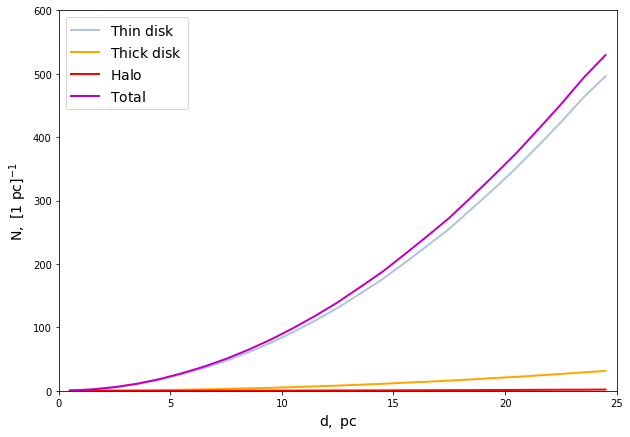

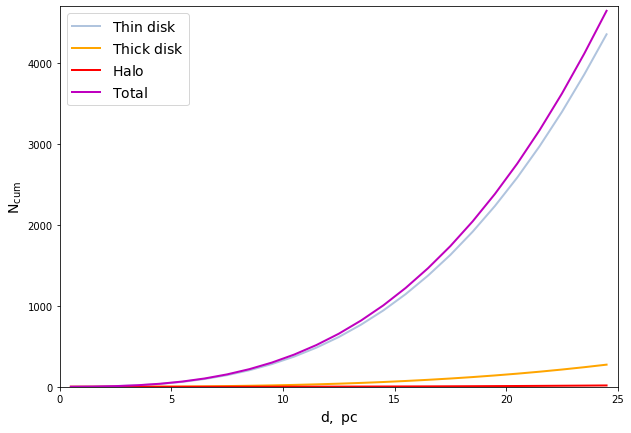

In [20]:
# Spatial distribution of stars (heliocentric distance)
# -------------------------------------------------------

cols = ['lightsteelblue','orange','r','m']

f, ax = plt.subplots(figsize=(10,7))
for i in range(3):
    ax.plot(dbinsc,Nd[i],lw=2,c=cols[i],label=components[i])
ax.plot(dbinsc,Nd[0]+Nd[1]+Nd[2],lw=2,c=cols[-1],label=components[-1])
ax.set_xlabel('$\mathrm{d, \ pc}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{N, \ [}$'+str(d_helio_step)+'$\mathrm{ \ pc]^{-1}}$',fontsize=fnt1)
ax.set_xlim(d_helio_min,d_helio_max)
ax.set_ylim(0,100*(np.amax(Nd[0])//100+2))
plt.legend(loc=2,prop={'size':fnt1})
plt.show()


f, ax = plt.subplots(figsize=(10,7))
for i in range(3):
    ax.plot(dbinsc,np.cumsum(Nd[i]),lw=2,c=cols[i],label=components[i])
ax.plot(dbinsc,np.cumsum(Nd[0])+np.cumsum(Nd[1])+np.cumsum(Nd[2]),lw=2,c=cols[-1],label=components[-1])
ax.set_xlabel('$\mathrm{d, \ pc}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{N_{cum}}$',fontsize=fnt1)
ax.set_xlim(d_helio_min,d_helio_max)
ax.set_ylim(0,100*(N_tot//100+2))
plt.legend(loc=2,prop={'size':fnt1})
plt.show()


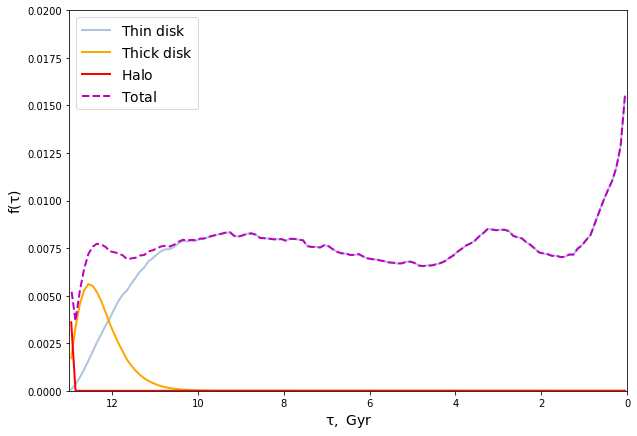

In [10]:
# Age distributions
# -------------------------------

# Smooth the distributions 
thistd_sm = convolve1d_gauss(thist[0],0.1,[0,tp])
thistt_sm = convolve1d_gauss(thist[1],0.1,[0,tp])
thistsh_sm = convolve1d_gauss(thist[2],0.1,[0,tp])
thisttot_sm = convolve1d_gauss(thist[0]+thist[1]+thist[2],0.1,[0,tp])

# Normalize to 1 
thistd_nm = thistd_sm/sum(thisttot_sm)
thistt_nm = thistt_sm/sum(thisttot_sm)
thistsh_nm = thistsh_sm/sum(thisttot_sm)
thisttot_nm = thisttot_sm/sum(thisttot_sm)
thist_nm = [thistd_nm,thistt_nm,thistsh_nm]

f, ax = plt.subplots(figsize=(10,7))
for i in range(3):
    ax.plot(tbinsc,thist_nm[i],lw=2,c=cols[i],label=components[i])
ax.plot(tbinsc,thisttot_nm,lw=2,c=cols[-1],label=components[-1],ls='--')
ax.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1)
ax.set_ylabel(r'$\mathrm{f(\tau)}$',fontsize=fnt1)
ax.set_xlim(tp,0)
ax.set_ylim(0,0.02*(np.amax(thisttot_nm)//0.02+1))
plt.legend(loc=2,prop={'size':fnt1})
plt.show()



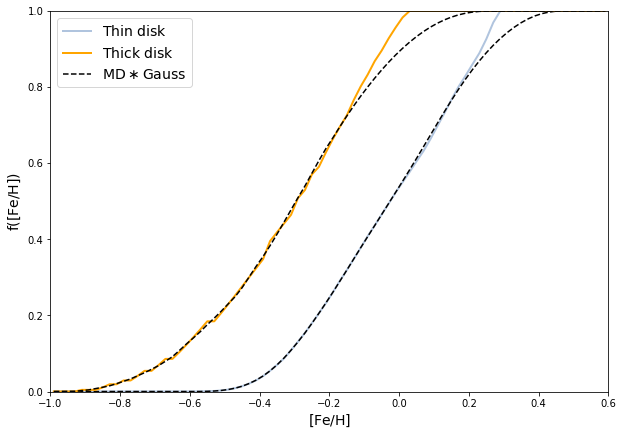

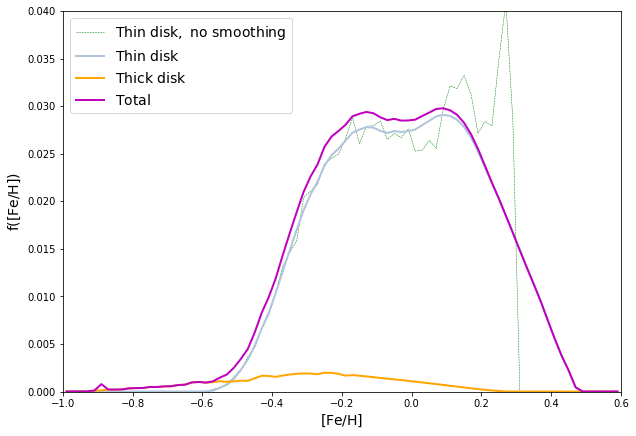

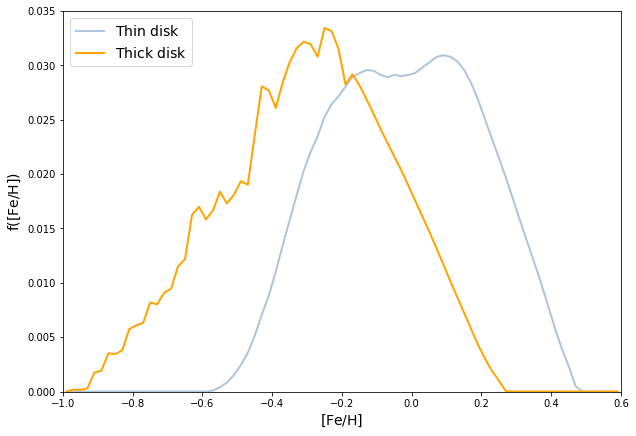

In [11]:
# Metallicity distributions
# -------------------------------

# Smooth the distributions. We convolve the upper part (N/N_tot>0.5) of the cumulative metallicity distributions 
# with a Gaussian kernel following the framework of Sysoliatina and Just (2021). This doesn't need to be applied 
# to the halo component. 

# Dispersions from Sysoliatina and Just (2021):
sigd_feh, sigt_feh = 0.1, 0.13


def convolve_methist(sigma_feh,fehist,febinsc):
    
    # Calculate cumulative metallicity distribution and define its upper part:
    fehist_cum = np.cumsum(fehist)
    ind_upper = np.where(fehist_cum/fehist_cum[-1]>0.5)[0]
    
    # Add dn points to its right and left side to avoid edge effects after convolution
    dn = 100
    fehist_cum_long = np.concatenate((np.linspace(0,0,dn),fehist_cum),axis=0)
    fehist_cum_long = np.concatenate((fehist_cum_long,np.linspace(fehist_cum[-1],fehist_cum[-1],dn)),axis=0)
    
    # Convolve with Gauss, cut out the extension tails 
    fehist_cum_full_sm = convolve1d_gauss(fehist_cum_long,sigma_feh,[febinsc[0],febinsc[-1]])[dn:-dn]
    
    # Construct total cumulative metallicity distribution 
    # (unchanged lower part + convolved upper part)
    fehist_cum_sm = np.concatenate((fehist_cum[:ind_upper[0]],fehist_cum_full_sm[ind_upper]),axis=0)
    
    # Smooth the obtained distribution with Savitsky-Golay filter (again, extra points are added at each side)
    fehist_cum_sm_long = np.concatenate((np.linspace(0,0,dn),fehist_cum_sm),axis=0)
    fehist_cum_sm_long = np.concatenate((fehist_cum_sm_long,
                                         np.linspace(fehist_cum_sm[-1],fehist_cum_sm[-1],dn)),axis=0)
    fehist_cum_sm = savgol_filter(fehist_cum_sm_long,11,3)[dn:-dn]
    fehist_cum_sm[fehist_cum_sm/fehist_cum_sm[-1]>1]=fehist_cum_sm[-1]
    fehist_cum_sm[fehist_cum_sm<0]=0
    
    # Return to non-cumulative distribution
    fehist_sm = np.concatenate(([fehist_cum_sm[0]],np.diff(fehist_cum_sm)),axis=0)
    
    return (fehist_cum, fehist_cum_sm, fehist_sm)


# Apply convolution
fehistd_cum, fehistd_cum_sm, fehistd_sm = convolve_methist(sigd_feh,fehist[0],febinsc)
fehistt_cum, fehistt_cum_sm, fehistt_sm = convolve_methist(sigt_feh,fehist[1],febinsc)
fehisttot_sm = fehistd_sm + fehistt_sm + fehist[2]

# Normalize distributions 
fehistd_nm = fehistd_sm/sum(fehisttot_sm)
fehistt_nm = fehistt_sm/sum(fehisttot_sm)
fehisttot_nm = fehisttot_sm/sum(fehisttot_sm)


f, ax = plt.subplots(figsize=(10,7))
ax.plot(febinsc,fehistd_cum/fehistd_cum[-1],c=cols[0],label=components[0],lw=2)
ax.plot(febinsc,fehistd_cum_sm/fehistd_cum_sm[-1],ls='--',c='k')
ax.plot(febinsc,fehistt_cum/fehistt_cum[-1],c=cols[1],label=components[1],lw=2)
ax.plot(febinsc,fehistt_cum_sm/fehistt_cum_sm[-1],ls='--',c='k',label=r'$\mathrm{MD \ast Gauss}$')
ax.set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{f([Fe/H])}$',fontsize=fnt1)
ax.set_xlim(febins[0],febins[-1])
ax.set_ylim(0,1)
plt.legend(loc=2,prop={'size':fnt1})
plt.show()


f, ax = plt.subplots(figsize=(10,7))
ax.plot(febinsc,fehist[0]/sum(fehisttot_sm),ls='--',lw=0.5,c='g',label='$\mathrm{Thin \ disk, \ no \ smoothing}$')
ax.plot(febinsc,fehistd_nm,lw=2,c=cols[0],label=components[0])
ax.plot(febinsc,fehistt_nm,lw=2,c=cols[1],label=components[1])
ax.plot(febinsc,fehisttot_nm,lw=2,c=cols[-1],label=components[-1])
ax.set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{f([Fe/H])}$',fontsize=fnt1)
ax.set_xlim(febins[0],febins[-1])
plt.legend(loc=2,prop={'size':fnt1})
ax.set_ylim(0,0.005*(np.amax(fehisttot_nm)//0.005+3))
plt.show()


f, ax = plt.subplots(figsize=(10,7))
ax.plot(febinsc,fehistd_sm/sum(fehistd_sm),lw=2,c=cols[0],label=components[0])
ax.plot(febinsc,fehistt_sm/sum(fehistt_sm),lw=2,c=cols[1],label=components[1])
ax.set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{f([Fe/H])}$',fontsize=fnt1)
ax.set_xlim(febins[0],febins[-1])
plt.legend(loc=2,prop={'size':fnt1})
ax.set_ylim(0,0.005*(np.amax([np.amax(fehistd_nm),np.amax(fehistt_nm)])//0.005+2))
plt.show()


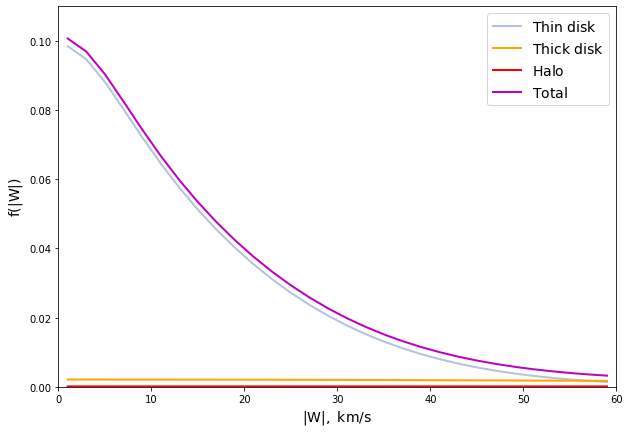

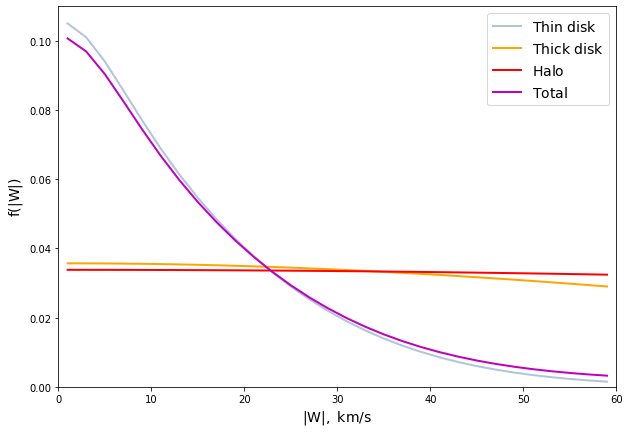

In [12]:
# |W|-velocity distributions
# --------------------------------

# Get total distribution and normalize to 1 
fwtot = fw[0] + fw[1] + fw[2]
fwtot_nm = fwtot/sum(fwtot)
fwd_nm = fw[0]/sum(fwtot)
fwt_nm = fw[1]/sum(fwtot)
fwsh_nm = fw[2]/sum(fwtot)

fw_nm = [fwd_nm,fwt_nm,fwsh_nm]

# Total f(|W|) with contributions from components
f, ax = plt.subplots(figsize=(10,7))
for i in range(3):
    ax.plot(wbinsc,fw_nm[i],lw=2,c=cols[i],label=components[i])
ax.plot(wbinsc,fwtot_nm,lw=2,c=cols[-1],label=components[-1])
ax.set_xlabel('$\mathrm{|W|, \ km/s}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{f(|W|)}$',fontsize=fnt1)
ax.set_xlim(0,wbins[-1])
ax.set_ylim(0,0.01*(np.amax(fwtot_nm)//0.01+1))
plt.legend(loc=1,prop={'size':fnt1})
plt.show()


# f(|W|) of components and total normalized separately 
f, ax = plt.subplots(figsize=(10,7))
ax.plot(wbinsc,fw[0]/sum(fw[0]),lw=2,c=cols[0],label=components[0])
ax.plot(wbinsc,fw[1]/sum(fw[1]),lw=2,c=cols[1],label=components[1])
ax.plot(wbinsc,fw[2]/sum(fw[2]),lw=2,c=cols[2],label=components[2])
ax.plot(wbinsc,fwtot_nm,lw=2,c=cols[-1],label=components[-1])
ax.set_xlabel('$\mathrm{|W|, \ km/s}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{f(|W|)}$',fontsize=fnt1)
ax.set_xlim(0,wbins[-1])
ax.set_ylim(0,0.01*(np.amax(fwtot_nm)//0.01+1))
plt.legend(loc=1,prop={'size':fnt1})
plt.show()



In [13]:
# Sky map 
# ----------------------------

# We use healpixels to map the distribution of stars over the sky (see https://healpix.jpl.nasa.gov/)

nside = 8                  # must be 2^n, defines size of hpixels
hpix, hpix_counts = [],[]

# Convert lb-map to hpixels (this may take a while)
for i in range(bnum):
    for k in range(lnum):
        n = lb_map[0][k,i]
        gc = SkyCoord(l=lbinsc[k]*u.degree,b=bbinsc[i]*u.degree,frame='galactic')
        eq = gc.transform_to('icrs')
        phi = np.deg2rad(eq.ra.value)
        teta = np.pi/2 - np.deg2rad(eq.dec.value)
        hpix.extend([hp.ang2pix(nside,teta,phi,nest=True)])
        hpix_counts.extend([n])
    #if i%10==0:
    #    print(i)

hpix_counts = np.array(hpix_counts)
uhpix = np.unique(hpix)
uhpix_counts = []
for i in range(len(uhpix)):
    ind = np.where(hpix==uhpix[i])[0]
    uhpix_counts.extend([sum(hpix_counts[ind])])


0.0 180.0 -180.0 180.0


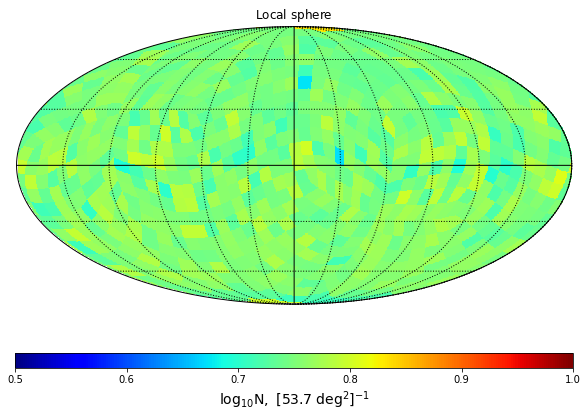

In [14]:
# Prepare the plot

hpix_list = np.arange(hp.nside2npix(nside),dtype=np.double)
lb_map_hpix = np.zeros((len(hpix_list)))

for i in range(len(uhpix_counts)):
    ind = np.where(hpix_list==uhpix[i])[0]
    lb_map_hpix[ind] += uhpix_counts[i]
    
for i in range(len(hpix_list)):
    try:
        lb_map_hpix[i] = np.log10(lb_map_hpix[i])
    except:
        pass

hpix_area = round(41253/len(hpix_list),1)        # 41253 deg^2 = all sky 
mmin, mmax = 0.5, 1 
cmap = cm.jet

f = plt.figure(figsize=(10,7))
mollview(lb_map_hpix,coord=['C','G'],nest=True,cmap=cmap,min=mmin,max=mmax,notext=True,fig=1,
         cbar=False,title='$\mathrm{Local \ sphere}$',hold=True)
graticule()
cax = f.add_axes([0.125, 0.1, 0.775, 0.03])
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')
cb.set_label(r'$\mathrm{\log_{10}N, \ [}$'+str(hpix_area)+'$\mathrm{\ deg^2]^{-1}}$',fontsize=fnt1)
cb.solids.set_edgecolor("face")
plt.show()
